# Data Preparation from SGX

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime

## Get stock data from SGX Stock Screener website

- Download the stocks from here: https://investors.sgx.com/stock-screener
- Move the file to same folder as this notebook and rename to `sgx.csv`
- After that, run the code cells below to obtain the necessary information from the `yfinance` package

In [2]:
df = pd.read_csv("sgx.csv")
df.head()

,Trading Name,Code,Last Price,ROE %,Market Cap ($M),Tot. Rev ($M),P/E,Yield (%),Sector,GTI Score
0,Tai Sin Electric,500,0.410,7.0913,188.707,440.030,8.007813,5.73,Industrials,78.0
1,HS Optimus,504,0.001,-3.8732,5.381,15.106,NaN,NaN,Consumer Cyclical,67.0
2,AsiaMedic,505,0.012,7.3315,13.854,28.915,13.333333,NaN,Healthcare,66.0
3,Fuji Offset,508,0.395,3.0376,19.715,3.628,20.466321,1.27,Industrials,70.0
4,DISA,532,0.001,-106.1844,10.689,8.082,NaN,NaN,Technology,34.0


## Create necessary features

The independent variable features to create:

|No.|Independent Variable|Formula|Measures|
|:---:|---|:---:|---|
|1|Debt Ratio|$\frac{\text{Total Debt}}{\text{Total Assets}}$|Solvency|
|2|Debt-to-Equity Ratio|$\frac{\text{Total Debt}}{\text{Total Equity}}$|Leverage|
|3|Current Ratio|$\frac{\text{Current Assets}}{\text{Current Liabilities}}$|Liquidity|
|4|Interest Coverage Ratio|$\frac{\text{EBIT}}{\text{Interest Expense}}$|Debt servicing ability|
|5|Gross Margin|$\frac{\text{Gross Profit}}{\text{Total Revenue}}$|Pre-operating profitability|
|6|Net Profit Margin|$\frac{\text{Net Income}}{\text{Total Revenue}}$|Bottom-line efficiency|
|7|Asset Turnover|$\frac{\text{Total Revenue}}{\text{Total Assets}}$|Efficiency measure|
|8|Log Market Cap|$\ln (\text{Total Assets})$|Size control|

The dependent features to create:

|No.|Dependent Variable|Formula|Measures|
|:---:|---|:---:|---|
|1|Return on Assets (ROA)|$\frac{\text{Net Income}}{\text{Total Assets}}$|Overall profitability|
|2|Return on Equity (ROE) |$\frac{\text{Net Income}}{\text{Total Equity}}$|Shareholder profitability|
|3|Operating Margin|$\frac{\text{Operating Income (EBIT)}}{\text{Total Revenue}}$|Core operational efficiency|
|4|Cash Flow Margin|$\frac{\text{Operating Cash Flow}}{\text{Total Revenue}}$|Cash-generating efficiency|

Required line items from financials:
|No.|Line Item|Location in Financial Statements|
|:---:|---|:---:|
|1|Total Assets|Balance Sheet|
|2|Total Debt|Balance Sheet|
|3|Total Equity|Balance Sheet|
|4|Current Assets|Balance Sheet|
|5|Current Liabilities|Balance Sheet|
|6|Net Income|Income Statement|
|7|Total Revenue|Income Statement|
|8|EBIT (Earnings before Interest & Taxes)|Income Statement|
|9|Interest Expense|Income Statement|
|10|Gross Profit|Income Statement|
|11|Operating Cash Flow|Cash Flow Statement|

In [3]:
sgx_df = df[["Trading Name", "Sector"]].copy()
sgx_df["Ticker"] = df["Code"] + ".SI"
sgx_df

,Trading Name,Sector,Ticker
0,Tai Sin Electric,Industrials,500.SI
1,HS Optimus,Consumer Cyclical,504.SI
2,AsiaMedic,Healthcare,505.SI
3,Fuji Offset,Industrials,508.SI
4,DISA,Technology,532.SI
...,...,...,...
616,StarhillGbl Reit,Real Estate,P40U.SI
617,Stoneweg Reit EUR,Real Estate,CWBU.SI
618,Stoneweg Reit SGD,Real Estate,CWCU.SI
619,Suntec Reit,Real Estate,T82U.SI


In [4]:
# Get stocks with the relevant data (include no null values) and ignore the rest
res = []
tickers_bad_data = []

# Only select stocks with all FS line items (no nulls) for the relevant time period (2021 to 2024)
necessary_line_items = ["TotalAssets", "TotalDebt", "CommonStockEquity", "CurrentAssets", "CurrentLiabilities", "NetIncome", "TotalRevenue", "EBIT", "InterestExpense", "GrossProfit", "OperatingCashFlow"]
sgx_tickers = sgx_df["Ticker"]

for t in sgx_tickers:
    ticker_data = yf.Ticker(t)

    if ticker_data.get_balancesheet().empty:
        print(f"No data for ticker {t}")
        tickers_bad_data.append(t)
        continue

    # Transpose to allow for easier calculation of features
    ticker_balancesheet = ticker_data.get_balancesheet().T
    ticker_incomestmt = ticker_data.get_incomestmt().T
    ticker_cashflow = ticker_data.get_cashflow().T

    ticker_financials = pd.concat([ticker_balancesheet, ticker_incomestmt, ticker_cashflow], axis=1)
    ticker_financials.index = pd.to_datetime(ticker_financials.index)

    # More checks to ensure data quality
    fiscal_years = ticker_financials.index.year
    if pd.Series(fiscal_years).duplicated().any():
        print(f"Duplicate FY end for ticker {t}")
        tickers_bad_data.append(t)
        continue    

    if not set(necessary_line_items).issubset(ticker_financials.columns):
        print(f"Missing FS line items for ticker {t}")
        tickers_bad_data.append(t)
        continue

    # Filter for years 2021 to current year
    relevant_data = ticker_financials[ticker_financials.index.year.isin(np.arange(2021, datetime.now().year))]

    # Check for nulls in any of the necessary line items
    if relevant_data[necessary_line_items].isnull().any(axis = None) or (relevant_data[necessary_line_items] == 0).any(axis = None):
        print(f"Incomplete/problematic data (nulls/zeros) in 2021–{datetime.now().year-1} for ticker {t}")
        tickers_bad_data.append(t)
        continue

    res.extend(ticker_financials.columns.tolist())


Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 508.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 566.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 570.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 581.SI
No data for ticker 600.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker LVR.SI
No data for ticker AZG.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 1Y1.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker AYV.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker WJ9.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 5EF.SI
No data for ticker 40F.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker S9B.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker BTX.SI
Incomplete/problematic data (nulls/zeros) in 2021–2024 for ticker 5RA.SI
Incomplete/problematic data (nulls/zeros) in 2

In [5]:
# Count how many stocks have all the necessary FS line items for analysis
item_counts = pd.Series(res).value_counts()
item_counts[item_counts.index.isin(necessary_line_items)].sort_values(ascending = False)

CurrentAssets         473
NetIncome             473
TotalAssets           473
EBIT                  473
InterestExpense       473
OperatingCashFlow     473
CurrentLiabilities    473
TotalRevenue          473
CommonStockEquity     473
TotalDebt             473
GrossProfit           473
Name: count, dtype: int64

After filtering out only stocks with the necessary financial statement line items and no nulls, we can finalise our independent and dependent variables and extract the necessary information from the `yfinance` package to create our dataframe and use it for our project.

## Create and run functions to get all necessary features

In [6]:
def get_ticker_financials(yf_ticker_name):
    ticker_data = yf.Ticker(yf_ticker_name)

    # Transpose to allow for easier calculation of features
    ticker_balancesheet = ticker_data.get_balancesheet().T
    ticker_incomestmt = ticker_data.get_incomestmt().T
    ticker_cashflow = ticker_data.get_cashflow().T

    # Combine all dataframe columns to get all FS line items together
    return pd.concat([ticker_balancesheet, ticker_incomestmt, ticker_cashflow], axis = 1)

def safe_divide(numerator, denominator):
    try:
        result = numerator / denominator
        result = result.mask((denominator == 0) | denominator.isna(), np.nan)
        return result
    except Exception:
        return np.nan

def create_ticker_features(ticker_name):
    # Get all financial line items from yfinance API
    df = get_ticker_financials(ticker_name)

    # Add independent variables
    df["debt_ratio"] = safe_divide(df.get("TotalDebt"), df.get("TotalAssets"))
    df["debt_equity_ratio"] = safe_divide(df.get("TotalDebt"), df.get("CommonStockEquity"))
    df["current_ratio"] = safe_divide(df.get("CurrentAssets"), df.get("CurrentLiabilities"))
    df["interest_coverage_ratio"] = safe_divide(df.get("EBIT"), df.get("InterestExpense"))
    df["gross_margin"] = safe_divide(df.get("GrossProfit"), df.get("TotalRevenue"))
    df["net_profit_margin"] = safe_divide(df.get("NetIncome"), df.get("TotalRevenue"))
    df["asset_turnover"] = safe_divide(df.get("TotalRevenue"), df.get("TotalAssets"))
    df["log_assets"] = np.log(df["TotalAssets"].astype(float))

    # Add dependent variables
    df["ROA"] = safe_divide(df.get("NetIncome"), df.get("TotalAssets"))
    df["ROE"] = safe_divide(df.get("NetIncome"), df.get("CommonStockEquity"))
    df["operating_margin"] = safe_divide(df.get("EBIT"), df.get("TotalRevenue"))
    df["cash_flow_margin"] = safe_divide(df.get("OperatingCashFlow"), df.get("TotalRevenue"))

    # Sort index (from latest FY to earliest FY) then add the FY ended
    df.sort_index(ascending = False, inplace = True)
    df = df.reset_index().rename(columns = {"index": "fy_ended"})
    df["fy_ended"] = df["fy_ended"].astype(str).str[:4].astype(int)

    # Add ticker name
    df["Ticker"] = ticker_name

    # Lag independent variables by 1 (Last year's financial ratios/metrics) to avoid simultaneous causality
    dep_vars = ["ROA", "ROE", "operating_margin", "cash_flow_margin"]
    indep_vars = ["debt_ratio", "debt_equity_ratio", "current_ratio", "interest_coverage_ratio", "gross_margin", "net_profit_margin", "asset_turnover", "log_assets"]
    for col in indep_vars:
        df[f"{col}_lag1"] = df[col].shift(-1, fill_value = np.nan)

    # Ignore all 2020 data (few stocks with data) 2021 (no lag data available) and current year because it is not over yet
    df = df[(df["fy_ended"] > 2021) & (df["fy_ended"] < datetime.now().year)]

    # Return only the X and Y variables used for analysis in the R project
    return pd.concat([df[["Ticker", "fy_ended"]], df[dep_vars + [var + "_lag1" for var in indep_vars]].astype(float)], axis = 1)

create_ticker_features("500.SI")

,Ticker,fy_ended,ROA,ROE,operating_margin,cash_flow_margin,debt_ratio_lag1,debt_equity_ratio_lag1,current_ratio_lag1,interest_coverage_ratio_lag1,gross_margin_lag1,net_profit_margin_lag1,asset_turnover_lag1,log_assets_lag1
0,500.SI,2024,0.046242,0.070556,0.056621,0.006499,0.151355,0.223236,2.835676,10.931291,0.158050,0.039538,1.396115,19.526173
1,500.SI,2023,0.055199,0.081414,0.055832,0.042883,0.136328,0.213398,2.442569,27.056351,0.211195,0.058055,1.200637,19.570331
2,500.SI,2022,0.069703,0.109109,0.074734,-0.019628,0.101749,0.156876,2.417933,28.295775,0.138630,0.057907,1.017493,19.496744


In [7]:
# Get all features from tickers with available financial data only
tickers_w_data = sgx_tickers[~sgx_tickers.isin(tickers_bad_data)]
df_list = [create_ticker_features(tick) for tick in tickers_w_data]
financials_df = pd.concat(df_list, axis = 0, ignore_index = True)
financials_df

,Ticker,fy_ended,ROA,ROE,operating_margin,cash_flow_margin,debt_ratio_lag1,debt_equity_ratio_lag1,current_ratio_lag1,interest_coverage_ratio_lag1,gross_margin_lag1,net_profit_margin_lag1,asset_turnover_lag1,log_assets_lag1
0,500.SI,2024,0.046242,0.070556,0.056621,0.006499,0.151355,0.223236,2.835676,10.931291,0.158050,0.039538,1.396115,19.526173
1,500.SI,2023,0.055199,0.081414,0.055832,0.042883,0.136328,0.213398,2.442569,27.056351,0.211195,0.058055,1.200637,19.570331
2,500.SI,2022,0.069703,0.109109,0.074734,-0.019628,0.101749,0.156876,2.417933,28.295775,0.138630,0.057907,1.017493,19.496744
3,504.SI,2024,-0.031169,-0.040117,-0.097365,-0.196616,0.077786,0.102127,9.548969,-38.683274,0.077676,-0.684918,0.152406,18.080316
4,504.SI,2023,-0.104386,-0.137052,-0.700899,-0.051341,0.088095,0.117281,7.193388,-17.476018,0.195743,-0.116155,0.185664,18.235900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,T82U.SI,2023,0.011391,0.019638,0.657338,0.543665,0.413571,0.749255,0.368553,4.765042,0.734050,1.115950,0.036483,23.183826
1370,T82U.SI,2022,0.040714,0.073760,1.522114,0.665115,0.420834,0.768610,0.473718,5.730559,0.699080,1.330579,0.030634,23.181887
1371,ODBU.SI,2024,0.037384,0.067855,0.725190,0.594560,0.427183,0.800510,0.662447,3.714247,0.653810,0.455785,0.089027,20.511010
1372,ODBU.SI,2023,0.040577,0.076038,0.756767,0.633852,0.428395,0.792051,1.730058,4.489794,0.640892,0.391191,0.085110,20.482344


In [8]:
final_df = pd.merge(sgx_df, financials_df, on = "Ticker", how = "right")
final_df.sort_values(by = ["Ticker", "fy_ended"], ascending = [True, False], inplace = True)
final_df

,Trading Name,Sector,Ticker,fy_ended,ROA,ROE,operating_margin,cash_flow_margin,debt_ratio_lag1,debt_equity_ratio_lag1,current_ratio_lag1,interest_coverage_ratio_lag1,gross_margin_lag1,net_profit_margin_lag1,asset_turnover_lag1,log_assets_lag1
635,Katrina,Consumer Cyclical,1A0.SI,2024,0.065511,-0.581296,0.085605,0.330708,0.874442,-5.815443,0.225997,0.358198,0.131754,-0.022726,1.363751,17.588134
636,Katrina,Consumer Cyclical,1A0.SI,2023,-0.030993,0.206116,0.016758,0.316463,0.886241,-8.695324,0.321686,2.192995,0.170886,0.053740,1.238624,17.767523
637,Katrina,Consumer Cyclical,1A0.SI,2022,0.066564,-0.653092,0.099072,0.330711,0.926730,-5.998423,0.400373,0.936720,0.000781,-0.003978,0.936513,17.866339
1220,Wong Fong Ind,Industrials,1A1.SI,2024,0.045659,0.063910,0.073631,0.175090,0.167445,0.248189,3.066291,11.614561,0.441571,0.047256,0.952752,18.220081
1221,Wong Fong Ind,Industrials,1A1.SI,2023,0.045023,0.066734,0.069576,0.139434,0.186017,0.321588,2.487539,7.925187,0.445504,0.029057,0.813313,18.343616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Ever Glory,Industrials,ZKX.SI,2023,0.274326,0.605854,0.181726,0.125658,0.068487,0.296421,1.309439,77.000000,0.103288,0.063152,2.182527,16.366517
377,Ever Glory,Industrials,ZKX.SI,2022,0.137832,0.596556,0.077055,-0.027269,0.077801,0.559529,1.142776,33.129613,0.042883,0.032249,2.184210,15.966633
108,Alpina Holdings,Industrials,ZXY.SI,2024,0.029490,0.080157,0.055447,0.138601,0.321498,0.753604,1.640927,1.429795,0.070668,-0.003507,0.991347,17.985565
109,Alpina Holdings,Industrials,ZXY.SI,2023,-0.003477,-0.008149,0.013015,-0.190199,0.192136,0.324024,2.568750,10.857678,0.138049,0.040811,1.055183,17.671577


In [9]:
# Check for NaNs in the dataframe
final_df[final_df.isnull().sum(axis = 1) > 0]

,Trading Name,Sector,Ticker,fy_ended,ROA,ROE,operating_margin,cash_flow_margin,debt_ratio_lag1,debt_equity_ratio_lag1,current_ratio_lag1,interest_coverage_ratio_lag1,gross_margin_lag1,net_profit_margin_lag1,asset_turnover_lag1,log_assets_lag1
398,FoodInnovators,Consumer Cyclical,KYB.SI,2022,0.006147,0.208917,0.035433,0.553546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
697,Livingstone,Healthcare,PRH.SI,2022,0.143452,0.605414,0.134534,0.136228,NaN,NaN,NaN,15.464286,0.823519,0.082369,NaN,NaN


In [11]:
# Remove the null rows
final_df = final_df[final_df.isnull().sum(axis = 1) == 0]
final_df.head()

,Trading Name,Sector,Ticker,fy_ended,ROA,ROE,operating_margin,cash_flow_margin,debt_ratio_lag1,debt_equity_ratio_lag1,current_ratio_lag1,interest_coverage_ratio_lag1,gross_margin_lag1,net_profit_margin_lag1,asset_turnover_lag1,log_assets_lag1
635,Katrina,Consumer Cyclical,1A0.SI,2024,0.065511,-0.581296,0.085605,0.330708,0.874442,-5.815443,0.225997,0.358198,0.131754,-0.022726,1.363751,17.588134
636,Katrina,Consumer Cyclical,1A0.SI,2023,-0.030993,0.206116,0.016758,0.316463,0.886241,-8.695324,0.321686,2.192995,0.170886,0.053740,1.238624,17.767523
637,Katrina,Consumer Cyclical,1A0.SI,2022,0.066564,-0.653092,0.099072,0.330711,0.926730,-5.998423,0.400373,0.936720,0.000781,-0.003978,0.936513,17.866339
1220,Wong Fong Ind,Industrials,1A1.SI,2024,0.045659,0.063910,0.073631,0.175090,0.167445,0.248189,3.066291,11.614561,0.441571,0.047256,0.952752,18.220081
1221,Wong Fong Ind,Industrials,1A1.SI,2023,0.045023,0.066734,0.069576,0.139434,0.186017,0.321588,2.487539,7.925187,0.445504,0.029057,0.813313,18.343616


In [12]:
# Check the descriptive statistics for any outliers
final_df.describe()

,fy_ended,ROA,ROE,operating_margin,cash_flow_margin,debt_ratio_lag1,debt_equity_ratio_lag1,current_ratio_lag1,interest_coverage_ratio_lag1,gross_margin_lag1,net_profit_margin_lag1,asset_turnover_lag1,log_assets_lag1
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,2022.994169,-0.030474,-0.005676,-0.107096,0.009046,0.279540,0.637958,2.480754,26.381998,0.334861,0.523479,0.710306,19.653913
std,0.816476,0.390509,0.985554,3.612219,2.673335,0.437167,1.828349,3.271184,527.595055,0.287546,26.654347,0.878741,2.402234
min,2022.000000,-8.865777,-16.676692,-85.024390,-66.743902,0.000102,-24.581486,0.040246,-8581.551606,-2.989819,-98.182927,-0.024831,13.432785
25%,2022.000000,-0.023542,-0.033418,-0.021585,0.006638,0.090899,0.122356,1.128851,-0.801705,0.160036,-0.055118,0.169344,18.007148
50%,2023.000000,0.016786,0.038109,0.064039,0.100014,0.224193,0.409696,1.647103,3.796209,0.285324,0.036030,0.537965,19.219091
75%,2024.000000,0.049787,0.105571,0.189806,0.256653,0.379622,0.875768,2.650745,12.803791,0.475886,0.121236,0.943041,21.047686
max,2024.000000,2.996056,16.907129,40.603261,30.668478,9.094403,33.362823,45.229126,7692.623762,2.217817,968.250000,11.484756,31.275583


## EDA: Check correlations between all features and targets

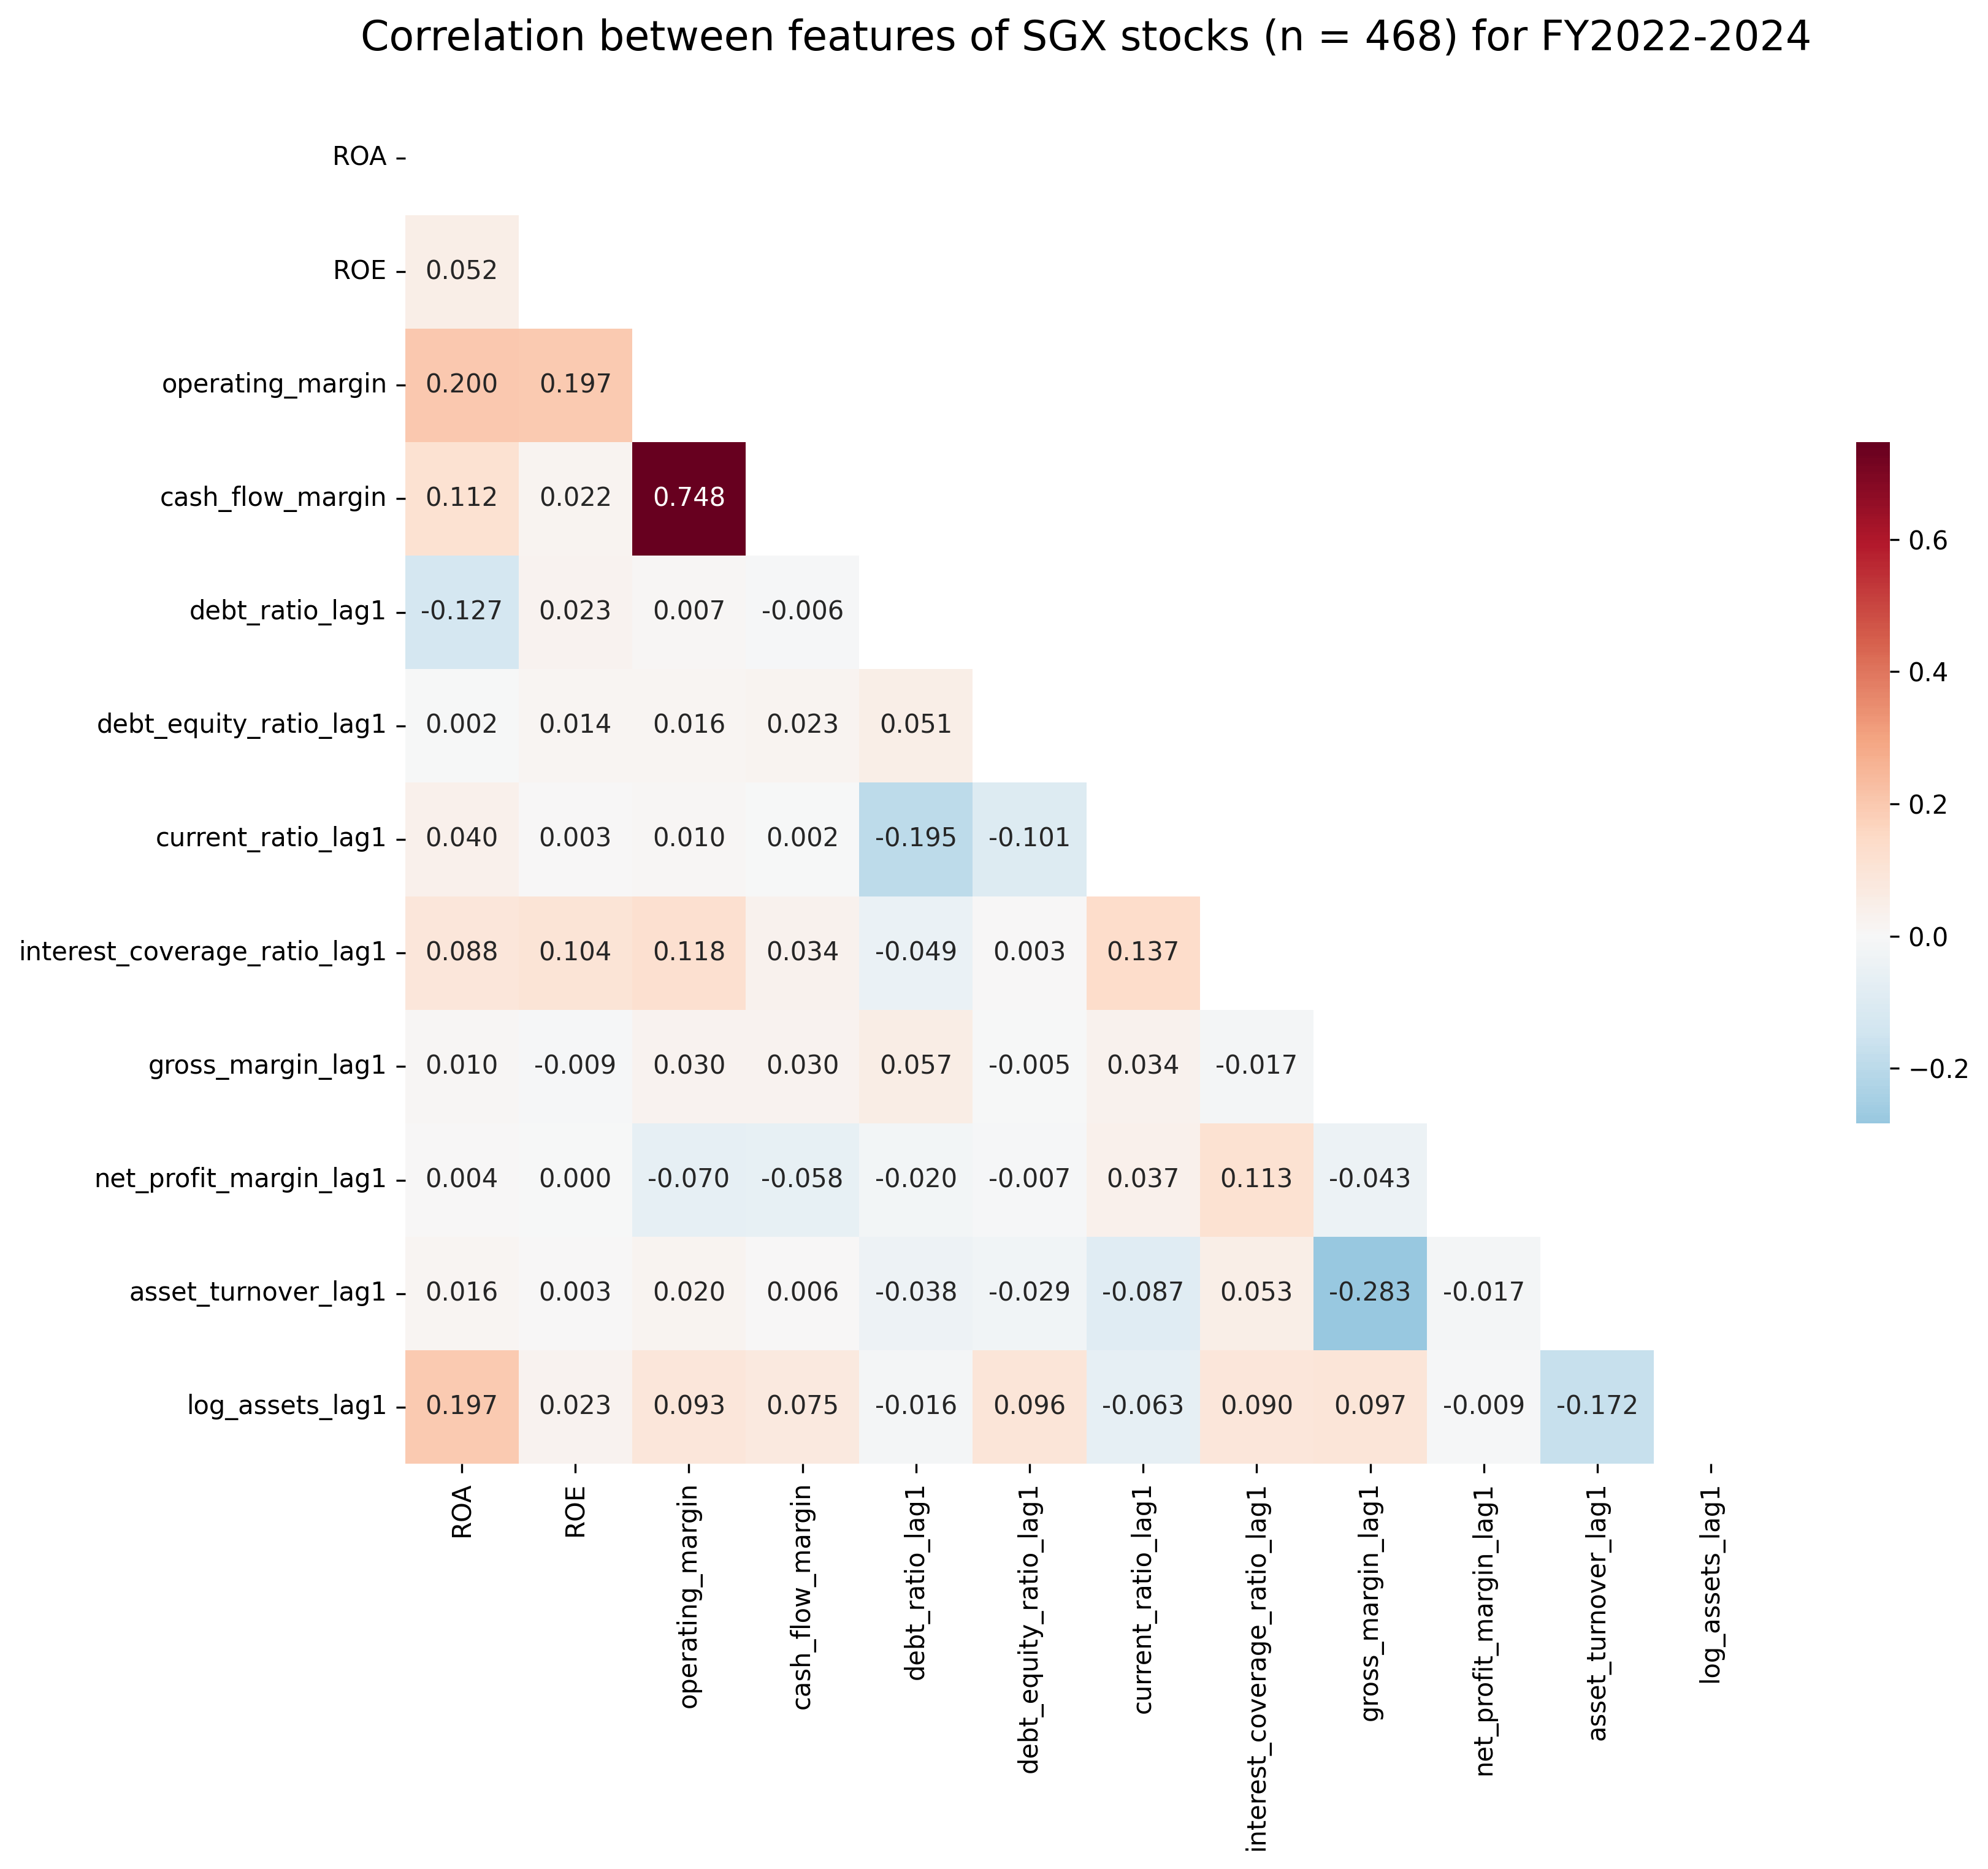

In [13]:
# Create correlation matrix
corr_matrix = final_df.iloc[:, 4:].corr()

# Visualise correlations using seaborn package
plt.figure(figsize = (12, 10), dpi = 300)
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))  # Mask upper triangle
sns.heatmap(
    corr_matrix,
    mask = mask, # Show only lower triangle
    annot = True,
    cmap = "RdBu_r", # Red-Blue colormap
    center = 0,
    square = True,
    fmt = ".3f",
    cbar_kws = {"shrink": 0.5}
)

plt.title(f"Correlation between features of SGX stocks (n = {final_df['Ticker'].nunique()}) for FY2022-{datetime.now().year-1}", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

## Output to `.csv` file

In [14]:
# Output dataframe to .csv file
final_df.to_csv("output.csv", index = False)
print("Conversion to .csv successful!")

Conversion to .csv successful!


Now that we have our final dataset, we can use it in our Shiny app for our OLS regression analysis.